In [6]:
import pandas as pd
import numpy as np
import re

# Load datasets
calls_df = pd.read_csv('calls.csv')
reasons_df = pd.read_csv('reasons.csv')
sentiment_df = pd.read_csv('sentiment_statistics.csv')

# Merge datasets on 'call_id'
merged_df = pd.merge(calls_df, reasons_df, on='call_id', how='left')
merged_df = pd.merge(merged_df, sentiment_df, on='call_id', how='left')

# Convert datetime columns to datetime objects
merged_df['call_start_datetime'] = pd.to_datetime(merged_df['call_start_datetime'])
merged_df['agent_assigned_datetime'] = pd.to_datetime(merged_df['agent_assigned_datetime'])
merged_df['call_end_datetime'] = pd.to_datetime(merged_df['call_end_datetime'])

# Calculate Handle Time (AHT)
merged_df['handle_time'] = (merged_df['call_end_datetime'] - merged_df['agent_assigned_datetime']).dt.total_seconds()


# Drop unnecessary columns
merged_df = merged_df.drop(columns=['agent_assigned_datetime', 'call_end_datetime'])

# Handle missing values
merged_df.fillna(method='ffill', inplace=True)  # Forward fill or use median/mode for specific columns

# Remove noise from call transcripts
ignore_words = ['agent', 'customer', 'thank', 'please', 'welcome', 'you', 'your', 'calling']

def clean_transcripts(text):
    # Remove comments within '**'
    text = re.sub(r'\*\*.*?\*\*', '', text)
    # Remove speaker labels like "Agent:" and "Customer:"
    text = re.sub(r'(Agent:|Customer:)', '', text)
    # Remove ignore words
    words = [word for word in text.split() if word.lower() not in ignore_words]
    return ' '.join(words)

merged_df['cleaned_transcript'] = merged_df['call_transcript'].apply(clean_transcripts)

print("Preprocessing complete.")


<ipython-input-6-d3721b1fdca7>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)  # Forward fill or use median/mode for specific columns


Preprocessing complete.


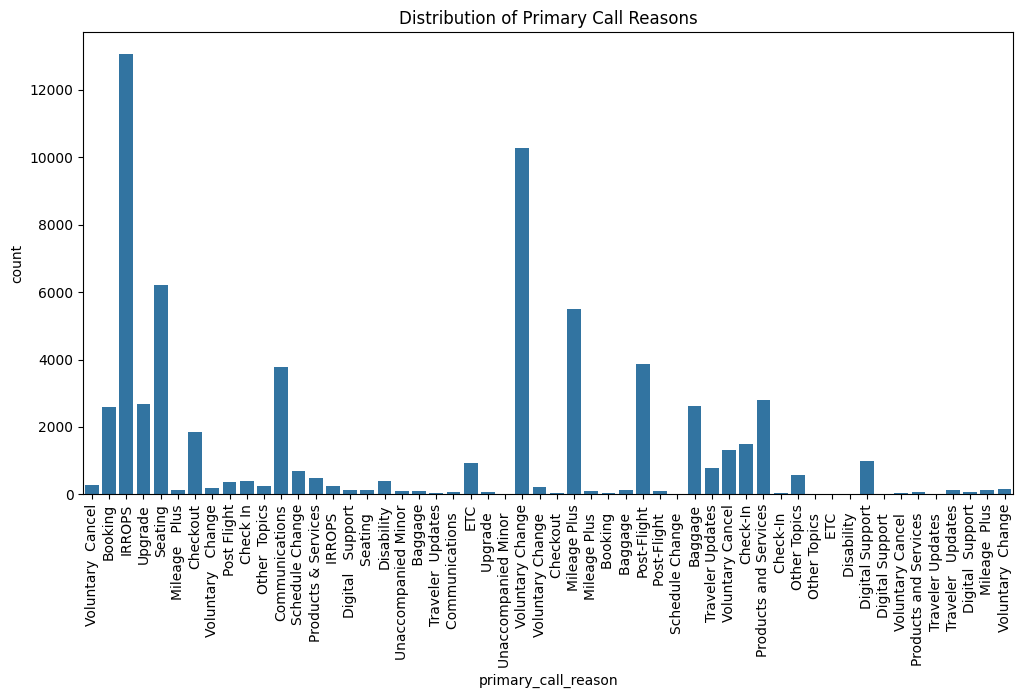

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


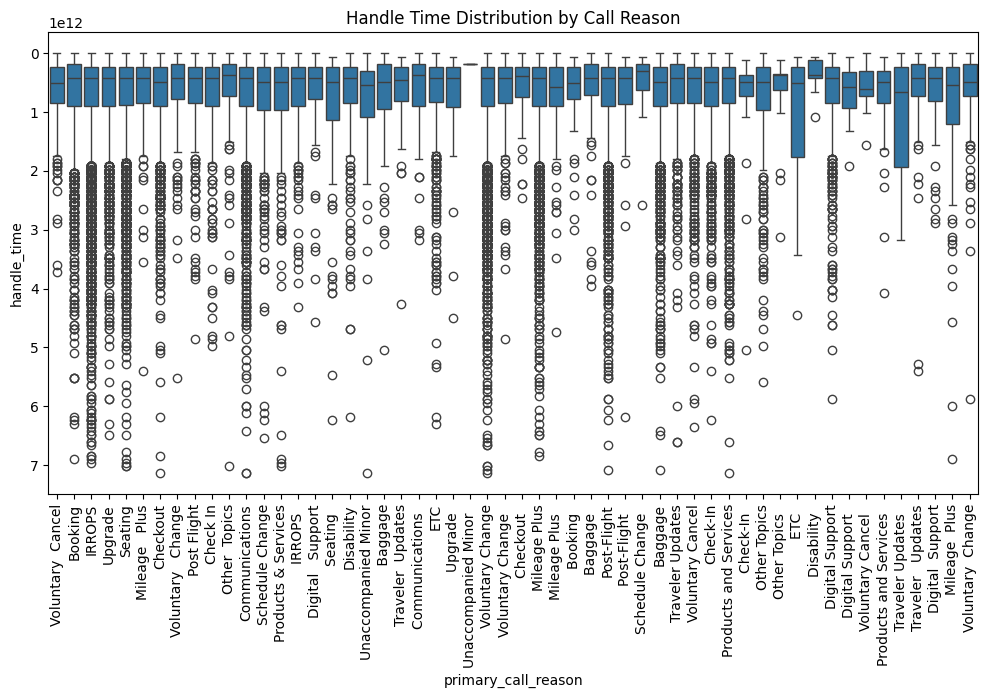

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Analyze the distribution of call reasons
plt.figure(figsize=(12, 6))
sns.countplot(data=reasons_df, x='primary_call_reason')
plt.xticks(rotation=90)
plt.title('Distribution of Primary Call Reasons')
plt.show()

# Analyze call duration by call reason
reasons_df['handle_time'] = pd.to_datetime(calls_df['call_end_datetime']) - pd.to_datetime(calls_df['agent_assigned_datetime'])
plt.figure(figsize=(12, 6))
sns.boxplot(data=reasons_df, x='primary_call_reason', y='handle_time')
plt.xticks(rotation=90)
plt.title('Handle Time Distribution by Call Reason')
plt.show()

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf.fit_transform(merged_df['cleaned_transcript'])

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
print("TF-IDF feature extraction complete.")



TF-IDF feature extraction complete.


In [11]:
from sklearn.preprocessing import LabelEncoder

# Combine features (TF-IDF + other metadata)
X = pd.concat([tfidf_df, merged_df[['handle_time', 'agent_tone', 'customer_tone', 'average_sentiment']]], axis=1)
y = merged_df['primary_call_reason']  # Target

# Create a LabelEncoder object
le = LabelEncoder()

# Fit and transform the 'agent_tone' and 'customer_tone' columns
X['agent_tone'] = le.fit_transform(X['agent_tone'])
X['customer_tone'] = le.fit_transform(X['customer_tone'])


print("Feature engineering complete.")


Feature engineering complete.
